In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Import the monitoring scripts
import sys
sys.path.insert(0, '../../src/monitoring_algorithms/')

%matplotlib inline


from IPython.display import set_matplotlib_formats
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

In [243]:
store = pd.HDFStore('../../data/processed/orbf_benin.h5')
data_orbf = store['data']
tarifs = store['tarifs']
store.close()

monitoring_data = open( "../../data/processed/facilities_supervision_trails.pkl", "rb" )
monitored_facilities = pickle.load(monitoring_data)
monitoring_data.close()




pkl_file = open( '../../data/processed/TEMP_aedes_fulldata.pkl', 'rb')
aedes_data = pickle.load(pkl_file)
pkl_file.close()

## Introduction

### Some terminology

To differentiate the different types of data that are being handled in the analysis, we will use the following taxonomy :

1. __Claimed data__ is the data sent by the facilities, before any level of verification happens.
2. __Verified data__ is the data verified by OpenRBF teams during supervisions
3. __Validated data__ is the data on which the payment is finally based. This can be the original claimed data, if no verification was made, or it could be the verified data, if a verification was made.

### What are we monitoring ?

#### Data quality

Data quality is an essential element of RBF. Building the trust that the data communicated by facilities reflects the demonstrable results of these facilities is essential to involving funders and other stakeholders in an RBF project.

There are two detrimental situations of bad data quality : 
* __Over reporting__ when the claimed reports are excessively important and do in no way reflect the activity in the facility
* __Under reporting__ when claimed payments are way below the actual costs of the facility. In this situation, facilities will come to detrimental situations where they will be underfunded, which could affect their ability to provide proper services in the following months.


#### Service conformity

Data on services also provides a picture of the activities that are carried out in a facility. As such, they allow to check if a facility is really providing the services it should be providing.


### Definition of _out of control_ situations

We want to track situations where the data reported by the facilities are considered _out of control_, i.e situations where facilities report data that are not consistent with past reported data, or with situations in other facilities.

To Identify these situations, we have to 
1. Define _in control_ situation based on available data
2. Define a variation threshold above which we consider the situation to be _out of control_
3. Test the incoming data based on these 

In the OpenRBF situation, an definitions for the threshold can be based on different aspects :
1. % of variation of indicators from their expected value
2. % of variation of payment from their expected value
3. Difference between expected and actual payment, and comparison to the cost of supervision. This is what we call the budgetary criteria.

In [218]:
mean_supervision_cost = 170000
underfunding_max_risk = 0.5

In [219]:
def get_validation_set(monitored_facilities):
    out = []
    for i in range(len(monitored_facilities)):
        for date in list(monitored_facilities[i].reports.keys()):
            data = {'fac_id':monitored_facilities[i].facility_id , 
                   'report_date':date , 
                   'claimed_payment':monitored_facilities[i].reports[date].report_payment['claimed_payment'] , 
                   'verified_payment':monitored_facilities[i].reports[date].report_payment['verified_payment']
                   }
            out.append(data)
    return pd.DataFrame(out)

In [220]:
report_payment_data = get_validation_set(monitored_facilities)
report_payment_data['difference_amount'] = report_payment_data['claimed_payment'] - report_payment_data['verified_payment']
report_payment_data['ratio'] = report_payment_data['claimed_payment'] / report_payment_data['verified_payment']
report_payment_data['over_declaration'] = report_payment_data['difference_amount'] > mean_supervision_cost
report_payment_data['under_declaration'] = report_payment_data['ratio'] < underfunding_max_risk
report_payment_data['date'] = pd.to_datetime(report_payment_data['report_date'])

### Data Quality Description

#### Budgetary definition

Based on the available data the budgetary definition is based on two separate thresholds :
1. The difference between the expected payment for the facility and the claimed payment should not exceed the supervision cost
2. The claimed payment should not be less than half the expected payment

The mean monthly supervision cost based on data from Bluesquare appears to be 170 000 CFA Francs.

Based on these elements and on the recorded claimed and verified data, I can flag reports as being over or under reported. The distribution of these different situations is as follows :

In [221]:
out_sup = sum(report_payment_data.over_declaration) / len(report_payment_data)
out_inf = sum(report_payment_data.under_declaration)  / len(report_payment_data)

print('Over declaration :' + str(out_sup))
print('Under declaration :' + str(out_inf))

n_facilities = report_payment_data.fac_id.nunique()

n_over_fac = report_payment_data[report_payment_data.over_declaration].fac_id.nunique() / n_facilities
n_under_fac = report_payment_data[report_payment_data.under_declaration].fac_id.nunique() / n_facilities
print('Overdeclaring Facilities :' + str(n_over_fac))
print('Undedeclaring Facilities :' + str(n_under_fac))

Over declaration :0.0864794495072
Under declaration :0.00483541007997
Overdeclaring Facilities :0.46050670640834573
Undedeclaring Facilities :0.06259314456035768


Based on the validated data, we see that 8.6% of the reports were claiming excessive amounts that were over the cost of verification, while 0.5% of the reports were claiming amounts that would have resulted in an undefunding of the facilities activities. 

47% of the facilities reported did an _ooc_ overestimation at least once, and 6.7% did an _ooc_ underestimation at least once in the data.

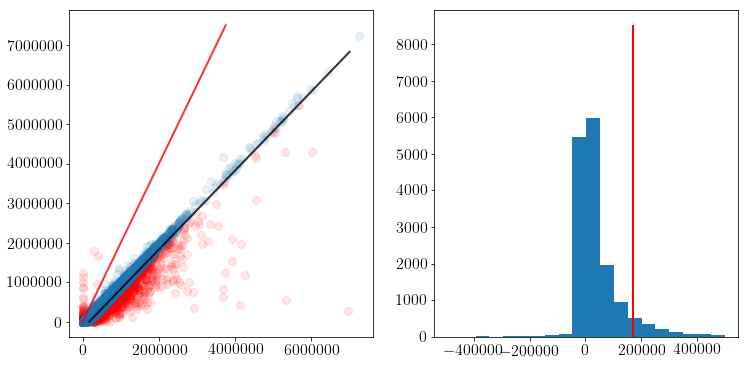

In [222]:
plotting_data = report_payment_data[(report_payment_data['claimed_payment'] < 10000000)]
report_payment_data['alarm'] = report_payment_data['over_declaration'] | report_payment_data['under_declaration']


outliers = plotting_data[plotting_data['over_declaration'] | plotting_data['under_declaration']]
in_control = plotting_data[~ (plotting_data['over_declaration']) & ~(plotting_data['under_declaration'])]

plt.figure(1)
plt.subplot(1,2,1)
plt.plot( outliers.claimed_payment , outliers.verified_payment , 'ro', alpha = 0.1)
plt.plot( in_control.claimed_payment , in_control.verified_payment , 'o' , alpha = 0.1)
plt.plot((0,3750000) , (0,7500000) , 'r-' , alpha = 0.8)
plt.plot((mean_supervision_cost,7000000) , (0,(7000000 - mean_supervision_cost)) , 'k-' , alpha = 0.8)
plotting_data = plotting_data[np.abs(plotting_data['difference_amount']) < 500000]
plt.subplot(1,2,2)
plt.hist(plotting_data[:]['difference_amount'] , bins = 20 )
plt.plot((mean_supervision_cost, mean_supervision_cost), (0, 8500), 'r-')

Graph 1 shows the distribution of the data we want to spot. Red data dots are outside of the zone in which we want the data to be. Reports under the black line were overreporting, and reports over the red line were underreporting too strongly before data validation.

#### Z-Score Definition

A second approach to spotting aberrant data is based on the divergence of the claimed data from its actual verified value. This divergenece can be measured using Z-Scores in different forms and flavours, as recommended and demonstrated by Spiegelhalter and others in various papers.

### Program Costs

In [223]:
mean_cost = mean_supervision_cost*len(report_payment_data) / sum(report_payment_data.verified_payment)
print('Share of verification cost : ' + str(mean_cost))

Share of verification cost : 0.288537407487


We see that in the current supervision regime, costs of verification represent 29 % of the overall program. This is an important cost, especially considering that 92% of the verifications are more costly than the reduction in payment they result in.

The process of data verification is thus costly and time consuming for public health authorities. The aim of this project is ot orient these efforts of supervision to maximize the chance of identifying data issues or services problems.

In [224]:
indicators_classif = pd.read_csv('../../references/indicators.csv' , encoding = "ISO-8859-1" )
data_orbf = data_orbf.merge(indicators_classif)

In [225]:
total_claimed_payments =  report_payment_data.groupby(['report_date']).claimed_payment.sum()
total_payments = report_payment_data.groupby(['report_date']).verified_payment.sum()
verification_costs = report_payment_data.groupby(['report_date']).verified_payment.apply(len) * mean_supervision_cost
total_cost = total_payments + verification_costs
perc_verification = verification_costs / total_cost
perc_alarms = report_payment_data.groupby(['report_date']).alarm.sum() / report_payment_data.groupby(['report_date']).alarm.apply(len)

N_overdecl = report_payment_data.groupby(['report_date']).over_declaration.sum()
N_underdecl = report_payment_data.groupby(['report_date']).under_declaration.sum()

perc_overdecl = N_overdecl / report_payment_data.groupby(['report_date']).alarm.apply(len)
perc_underdecl = N_underdecl / report_payment_data.groupby(['report_date']).alarm.apply(len)

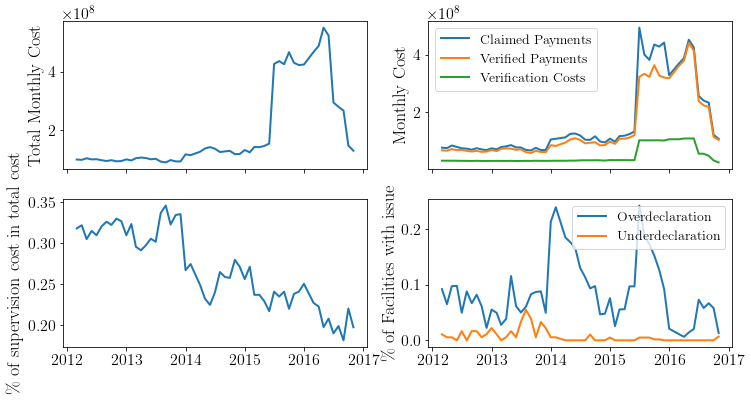

In [226]:
f, axarr = plt.subplots(2,2, sharex=True)
axarr[0,0].plot(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index) , total_cost[total_claimed_payments < 1e9].tolist())
axarr[0,0].set_ylabel('Total Monthly Cost')

axarr[0,1].plot(pd.to_datetime(total_claimed_payments[total_claimed_payments < 1e9].index) , total_claimed_payments[total_claimed_payments < 1e9].tolist() , label = 'Claimed Payments')
axarr[0,1].plot(pd.to_datetime(total_payments[total_claimed_payments < 1e9].index) , total_payments[total_claimed_payments < 1e9].tolist() , label = 'Verified Payments')
axarr[0,1].plot(pd.to_datetime(verification_costs[total_claimed_payments < 1e9].index) , verification_costs[total_claimed_payments < 1e9].tolist() , label = 'Verification Costs')
axarr[0,1].set_ylabel('Monthly Cost')
axarr[0,1].legend()

axarr[1,0].plot(pd.to_datetime(perc_verification[total_claimed_payments < 1e9].index) , perc_verification[total_claimed_payments < 1e9].tolist())
axarr[1,0].set_ylabel('\% of supervision cost in total cost')
axarr[1,1].plot(pd.to_datetime(perc_overdecl[total_claimed_payments < 1e9].index) , perc_overdecl[total_claimed_payments < 1e9].tolist() , label = 'Overdeclaration')
axarr[1,1].plot(pd.to_datetime(perc_underdecl[total_claimed_payments < 1e9].index)  , perc_underdecl[total_claimed_payments < 1e9].tolist() , label = 'Underdeclaration')
axarr[1,1].set_ylabel('\% of Facilities with issue')
axarr[1,1].legend()

## Methods

Based on this first presentation, we want to classify all incoming data in four categories :
1. __In control__ : will be for all the data that seems to follow expected distributions and evolutions
2. __Data Issue__ : will be for data with unexpected values, that can be linked to data quality issues. This includes :
    1. __Overestimation__ : will screen and spot the data that seems to be overshooting the expected values by too wide a margin, as previously defined
    2. __Underestimation__ : will screen and spot the data that seems to be underevaluating the expected payments by a too wide factor
4. __Quality issue__ : finally, we will aim at identifying reports that seem to show issues in the quality of care in the facility

### Building classification features

To do this classification, we will build features, characterizing the place of the observed values in the expected distributions. We will test 3 approaches to build these features.

The features will need to be built on different dimensions :
1. Internal consistency of each serie : surveillance
2. Facility consistency with other facilities : hierarchical
3. Profile consistency for the facility / Profile consistency with other facilities

#### Surveillance approach

In an Surveillance approach, we will want to monitor the amounts paid to a facility on a monthly basis, and spot a divergence from the expected _in control_ distribution. Methods for this are from a CUSUM family, and use control charts as output to present and interpret the results.

Essentially, in this approach, we want to check if any of the individual observed series in the reports are showing unexpected patterns. To do this, for each facility I will :
1. Model each report serie using an ARIMA based on historic data
2. Get a prediction for the new data
3. Compared the new data to the distribution of expected data 

#### Hierarchical modelling

A second approach is to model the values we should observe for different indicators, using 

#### Profile monitoring

Finally, we want to check intern consistency of reports. This consistency should be the defined both within facilties and among facilites.

### Classification

## Verification strategies testing

### Strategy 1 : Random Supervision

### Strategy 2 : Stratified random supervision

In [247]:
def get_interesting_quantities(validated_path):
    validated_path['claimed_payment'] = validated_path['indicator_claimed_value'] * validated_path['indicator_tarif']
    validated_path['validated_payment'] = validated_path['indicator_validated_value'] * validated_path['indicator_tarif']
    validated_path['verified_payment'] = validated_path['indicator_verified_value'] * validated_path['indicator_tarif']
    validated_path['net_saved_payment'] = validated_path['claimed_payment'] - validated_path['validated_payment']
    validated_path['undue_payment_made'] = validated_path['validated_payment'] - validated_path['verified_payment']
    return validated_path

def count_supervisions(validated_path):
    supervisions = validated_path[validated_path.trigger.isin([True , 'Initial Training'])]
    n_supervisions = supervisions.reset_index()['facility_name'].nunique() 
    return n_supervisions

payments_description= get_interesting_quantities(aedes_data)

aedes_monthly_verifications = aedes_data.groupby(level = 3).apply(count_supervisions)
aedes_supervision_cost = monthly_verifications * mean_supervision_cost

aedes_total_payment = payments_description['validated_payment'].groupby(level = 3).sum() + supervision_cost
aedes_share_supervision_cost = aedes_supervision_cost / aedes_total_payment
aedes_undue = payments_description['undue_payment_made'].groupby(level = 3).sum()

In [244]:
aedes_data

indicator_claimed_value  \
algorithm departement facility_name period  indicator_label                                                               
aedes     ATLANTIQUE  Csa Kpovie Mi 2012-03 Accouchement eutocique assiste                                          9.0   
                                            Accouchement eutocique assiste femme indigente ...                      0.0   
                                            Accouchement: reference d'urgence pour accouche...                      0.0   
                                            Consultation prenatale quatrieme visite standard                        7.0   
                                            Consultation prénatale quatrième visite standar...                      0.0   
                                            Depistage des cas TBC positifs                                          0.0   
                                            Enfants completement vaccines                                           3.0   
                                            Nombre de cas TBC traites et gueris                                     0.0   
                                            Nouvelle Consultation Curative                                        104.0   
                                            Reference et patient arrive a l'hopital                                 0.0   
                                            Suivi de la croissance: enfants de 11 a 59 mois...                      0.0   
                                    2012-04 Accouchement eutocique assiste                                          8.0   
                                            Accouchement eutocique assiste femme indigente ...                      0.0   
                                            Accouchement: reference d'urgence pour accouche...                      0.0   
                                            Consultation prenatale quatrieme visite standard                        1.0   
                                            Consultation prénatale quatrième visite standar...                      0.0   
                                            Depistage des cas TBC positifs                                          0.0   
                                            Enfants completement vaccines                                          11.0   
                                            Nombre de cas TBC traites et gueris                                     0.0   
                                            Nouvelle Consultation Curative                                        101.0   
                                            Reference et patient arrive a l'hopital                                 0.0   
                                            Suivi de la croissance: enfants de 11 a 59 mois...                      0.0   
                                    2012-05 Accouchement eutocique assiste                                         15.0   
                                            Accouchement eutocique assiste femme indigente ...                      0.0   
                                            Accouchement: reference d'urgence pour accouche...                      3.0   
                                            Consultation prenatale quatrieme visite standard                        8.0   
                                            Consultation prénatale quatrième visite standar...                      0.0   
                                            Depistage des cas TBC positifs                                          0.0   
                                            Enfants completement vaccines                                          10.0   
                                            Nombre de cas TBC traites et gueris                                     0.0   
...                                                                                                                 ...   
          ZOU         Mi Gossoe Mi  2

### Strategy 3 : Supervision every Cost alerts only

For each Facility, we obtain a supervision trail, that bases expected values on previously validated data on the 

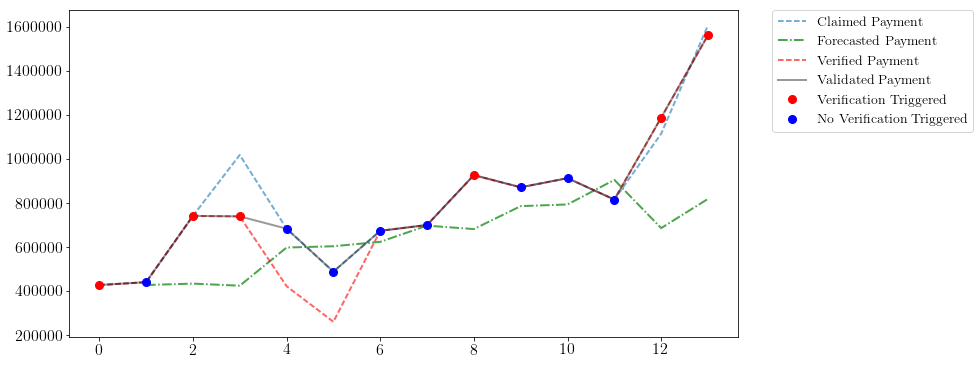

In [230]:
monitored_facilities[200].plot_supervision_trail(tarifs)

In [231]:
report_payment_data = report_payment_data.set_index(['fac_id' , 'report_date' ])

In [232]:
def get_report_validation(monitored_facility):
    out_def = ''
    reports_dates = list(monitored_facility.reports.keys())
    for date in reports_dates :
        data = {'sup_alarm':monitored_facility.reports[date].alarm , 'report_date':date , 
                'fac_id':monitored_facility.facility_id }
        if date == reports_dates[0] :
            out = [data]
        if (date == reports_dates[0]) == False : 
                out.append(data)
    out = pd.DataFrame(out)
    
    ## Payment
    indicators = list(monitored_facility.training_set.keys())
    payments = monitored_facility.training_set[indicators[0]] * tarifs[indicators[0]]
    for indic in indicators[1:]:
        payments = payments.add(monitored_facility.training_set[indic] * tarifs[indic] , fill_value=0)
    payment = pd.DataFrame(payments)
    payment = payment.reset_index()
    payment.columns = ['report_date' , 'validated_payment']
    payment['report_date'] = payment.report_date.astype(str).str[0:7]
    out = out.merge(payment , on = 'report_date' , how='outer')
    return out

def sensitivity(true_value , test_value):
    return sum((true_value == test_value) * true_value) / sum(true_value)

def npv(true_value , test_value):
    return sum((true_value == test_value) * ~true_value) / sum(test_value == False) 

out_df = get_report_validation(monitored_facilities[0])
for i in range(1 , len(monitored_facilities)):
    out = get_report_validation(monitored_facilities[i])
    out_df = out_df.append(out)
out_df = out_df.set_index(['fac_id' , 'report_date'])

print('Strategy Sensitivity : ' + str(sensitivity(report_payment_data['alarm'] , out_df['sup_alarm'])))
print('Strategy Negative Predictive Value : ' + str(npv(report_payment_data['alarm'] , out_df['sup_alarm'])))

Strategy Sensitivity : 0.619144602851
Strategy Negative Predictive Value : 0.954965079875


C:\Users\grlurton\Anaconda3\envs\orbf_monitoring\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


The Sensitivity of this strategy is somehow underwhelming, 62% of raised alarms have been identified by our approach. Meanwhile, less than 5% of the algorithmically validated reports turn out to be in fact problematic.

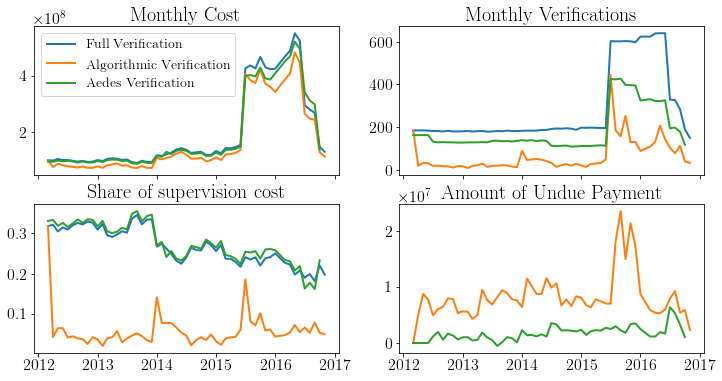

In [248]:
payments_sup = out_df.groupby(level = 1).validated_payment.sum()
verification_costs_sup = out_df.groupby(level = 1).sup_alarm.sum() * mean_supervision_cost
total_sup_cost = payments_sup + verification_costs_sup
perc_verification_sup = verification_costs_sup / total_sup_cost

N_verif_sup = out_df.groupby(level = 1).sup_alarm.sum()
N_verif_total = report_payment_data.groupby(level = 1).apply(len)

undue_payment = (out_df.validated_payment - report_payment_data.verified_payment)
undue_payment_plot = undue_payment.groupby(level= 1).sum()

f, axarr = plt.subplots(2,2, sharex=True)
axarr[0,0].plot(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index) , total_cost[total_claimed_payments < 1e9].tolist() , label = 'Full Verification')
axarr[0,0].plot(pd.to_datetime(total_sup_cost[total_claimed_payments < 1e9].index) , total_sup_cost[total_claimed_payments < 1e9].tolist() , label = 'Algorithmic Verification')
axarr[0,0].plot(aedes_total_payment[aedes_total_payment < 1e9].index.get_level_values(0).to_timestamp() , aedes_total_payment[aedes_total_payment < 1e9].tolist() , label = 'Aedes Verification')
axarr[0,0].set_title('Monthly Cost')
axarr[0,0].legend()


# N Verifications
axarr[0,1].plot(pd.to_datetime(N_verif_total[total_claimed_payments < 1e9].index) , N_verif_total[total_claimed_payments < 1e9].tolist())
axarr[0,1].plot(pd.to_datetime(N_verif_sup[total_claimed_payments < 1e9].index) , N_verif_sup[total_claimed_payments < 1e9].tolist())
axarr[0,1].plot(aedes_monthly_verifications[aedes_total_payment < 1e9].index.get_level_values(0).to_timestamp() , aedes_monthly_verifications[aedes_total_payment < 1e9].tolist())
axarr[0,1].set_title('Monthly Verifications')

axarr[1,0].plot(pd.to_datetime(perc_verification[total_claimed_payments < 1e9].index) , perc_verification[total_claimed_payments < 1e9].tolist())
axarr[1,0].plot(pd.to_datetime(perc_verification_sup[total_claimed_payments < 1e9].index) , perc_verification_sup[total_claimed_payments < 1e9].tolist())
axarr[1,0].plot(aedes_share_supervision_cost[aedes_total_payment < 1e9].index.get_level_values(0).to_timestamp() , list(aedes_share_supervision_cost[aedes_total_payment < 1e9]))
axarr[1,0].set_title('Share of supervision cost')

# % overdeclaration spotted
axarr[1,1].plot(pd.to_datetime(undue_payment_plot[total_claimed_payments < 1e9].index) , undue_payment_plot[total_claimed_payments < 1e9].tolist() , color = 'C1')
axarr[1,1].plot(aedes_undue[aedes_total_payment < 1e9].index.get_level_values(0).to_timestamp() , list(aedes_undue[aedes_total_payment < 1e9]) , color = 'C2')
axarr[1,1].set_title('Amount of Undue Payment')

Meanwhile, we see that the monthly cost of the program with algorithmic verification is slightly less expensive than the cost of full verification. This is due to the huge diminution in verification costs, as the total cost of supervision diminishes to little more than 5% of the total cost of the program.

In [228]:
undue_payment = (out_df.validated_payment - report_payment_data.verified_payment)
print('Amount Undue Payment : ' + str(undue_payment.sum()))

perc_undue_payment = undue_payment / report_payment_data.verified_payment

print('Percentage Undue Payment : ' + str(undue_payment.sum() / report_payment_data.verified_payment.sum()))
print('Percentage Undue Payment in total Cost : ' + str(undue_payment.sum() / total_sup_cost.sum()))

ValueError: cannot join with no level specified and no overlapping names

In the meantime, we see that with this strategy, 466 830 794 CFA Francs would been payed unduly to facilities, over 4 years. This, meanwhile, represents only 5% of the total payments made, and 4.4% of the total cost of the program on the period. We see that a big chunck of these costs happen around the introduction of new facilities, when the algorithms take some time to stabilize.

### Strategy 4 : Supervision for multiple diverging indicators

### Strategy 4 : Supervision for outlying cost / indicators

### Strategy 6 : Supervision for report profile modification

### Comparisons

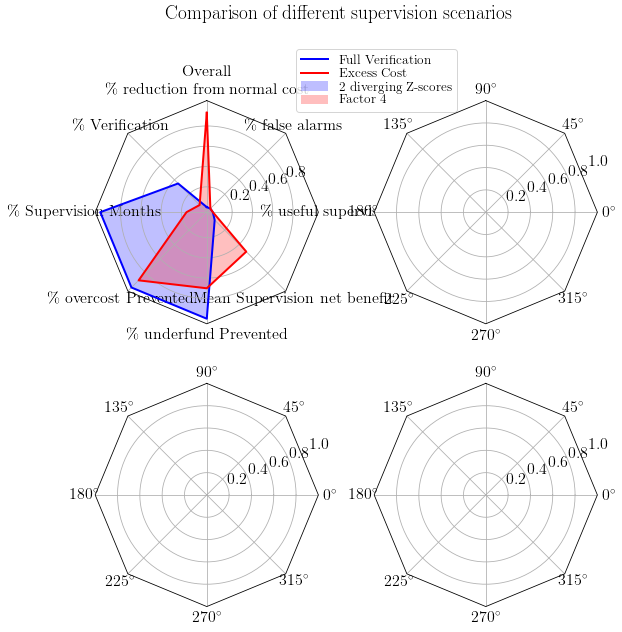

In [115]:
#from http://matplotlib.org/examples/api/radar_chart.html

"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

"""
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


dimensions = ['\% reduction from normal cost', '\% Verification', '\% Supervision Months', 
         '\% overcost Prevented', '\% underfund Prevented', 'Mean Supervision net benefit', 
         '\% useful supervision', '\% false alarms']

def example_data():
    data = [
        dimensions ,
        ('Overall', [
            [0, 0.35 , 1 , 1, 1, 0.06, 0.01, 0.00],
            [1-  0.07,   0.05,   0.15 ,  0.9 , 0.7, 
             0.5, 0.01, 0.00]]) #,
  #      ('M0-M12', [
  #          [1, strat_1_cost['perc_supervision'] , 1 , 1, 0.00, 0.06, 0.01, 0.00],
  #          [strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
  #           perc_months_supervisions2, per_overcost_prevented2, 0.00, 0.02, 0.01, 0.00],
  #          [strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
  #           perc_months_supervisions3, per_overcost_prevented3 , 0.05, 0.10, 0.00, 0.00]]),
  #      ('M12-M36', [
  #          [1, strat_1_cost['perc_supervision'] , 1 , 1, 0.00, 0.06, 0.01, 0.00],
  #          [strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
  #           perc_months_supervisions2, per_overcost_prevented2, 0.00, 0.02, 0.01, 0.00],
  #          [strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
  #           perc_months_supervisions3, per_overcost_prevented3 , 0.05, 0.10, 0.00, 0.00]]),
  #      ('> M36', [
  #          [1, strat_1_cost['perc_supervision'] , 1 , 1, 0.00, 0.06, 0.01, 0.00],
  #          [strat_2_cost['total_cost'] /strat_1_cost['total_cost'],  strat_2_cost['perc_supervision'], 
  #           perc_months_supervisions2, per_overcost_prevented2, 0.00, 0.02, 0.01, 0.00],
  #          [strat_3_cost['total_cost'] / strat_1_cost['total_cost'], strat_3_cost['perc_supervision'] , 
  #           perc_months_supervisions3, per_overcost_prevented3 , 0.05, 0.10, 0.00, 0.00]])
    ]
    return data


N = len(dimensions)

if __name__ == '__main__':
    N = N
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Full Verification', 'Excess Cost', '2 diverging Z-scores', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, 'Comparison of different supervision scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.show()